In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
np.random.seed(42)
train_path = 'insurance_train.csv'
test_path = 'insurance_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print("Данные успешно загружены.")
full_df = pd.read_csv('insurance.csv')
train_size = int(0.8 * len(full_df))
df_train = full_df.iloc[:train_size].copy()
df_test = full_df.iloc[train_size:].copy()
import os
os.makedirs('datasets', exist_ok=True)
df_train.to_csv(train_path, index=False)
df_test.to_csv(test_path, index=False)
print("Файлы train/test созданы из insurance.csv")

print(f"Размер обучающей выборки: {df_train.shape}")
print(f"Размер тестовой выборки: {df_test.shape}")
df_train.head()

Данные успешно загружены.
Файлы train/test созданы из insurance.csv
Размер обучающей выборки: (1070, 7)
Размер тестовой выборки: (268, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Пропуски в обучающей выборке:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


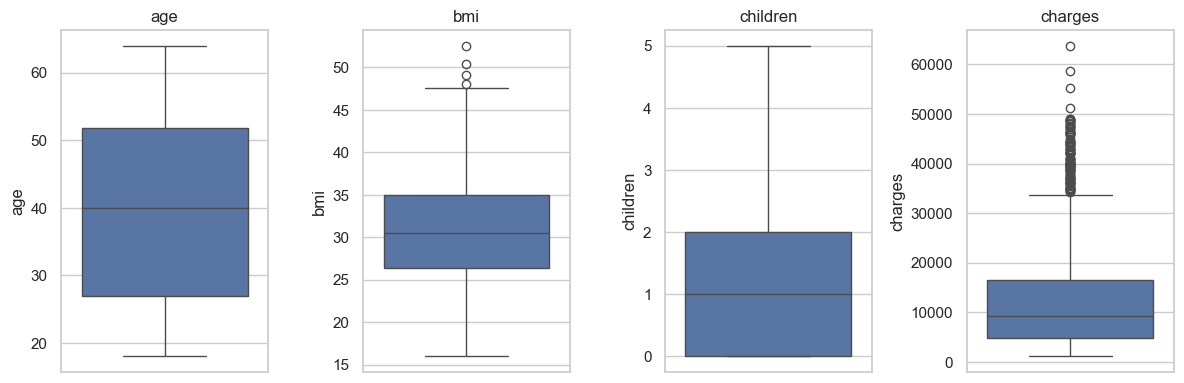

Пример обработанных данных:


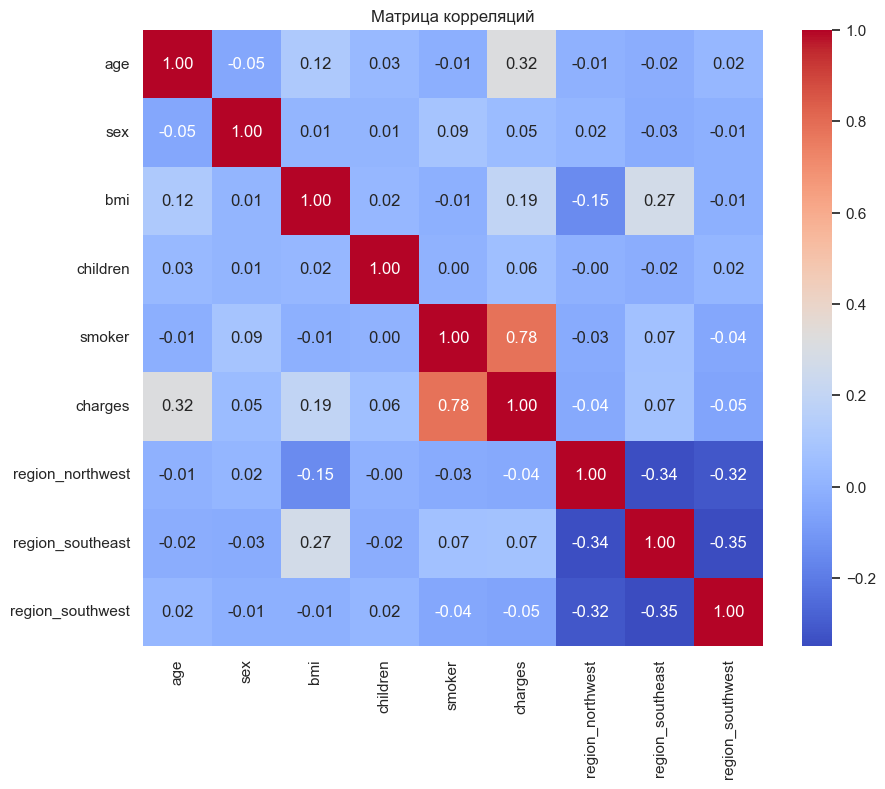

In [4]:
# 1.1 Проверка на пропуски
print("Пропуски в обучающей выборке:")
print(df_train.isnull().sum())

# 1.2 Поиск выбросов 
num_cols = ['age', 'bmi', 'children', 'charges']
plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df_train[col])
    plt.title(col)
plt.tight_layout()
plt.show()

def preprocess_data(df, is_train=True, encodings=None):
 
    df_proc = df.copy()
    

    df_proc['sex'] = df_proc['sex'].map({'female': 0, 'male': 1})

    df_proc['smoker'] = df_proc['smoker'].map({'no': 0, 'yes': 1})
    
    df_proc = pd.get_dummies(df_proc, columns=['region'], prefix='region', drop_first=True) 
    
    for col in df_proc.columns:
        if 'region_' in col:
            df_proc[col] = df_proc[col].astype(int)
            
    return df_proc

df_train_proc = preprocess_data(df_train)
df_test_proc = preprocess_data(df_test)

missing_cols = set(df_train_proc.columns) - set(df_test_proc.columns)
for c in missing_cols:
    df_test_proc[c] = 0
    
df_test_proc = df_test_proc[df_train_proc.columns]

print("Пример обработанных данных:")
df_train_proc.head()

# 1.3 Вычисление парных корреляций
plt.figure(figsize=(10, 8))
corr_matrix = df_train_proc.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций")
plt.show()


Размер матрицы X_train: (1070, 9)
Веса (Аналитическое решение): [13214.1258132   3667.98588468  -126.87434576  2062.82119905
   523.23706138  9477.91275996  -200.68458214  -499.64634368
  -534.36454133]


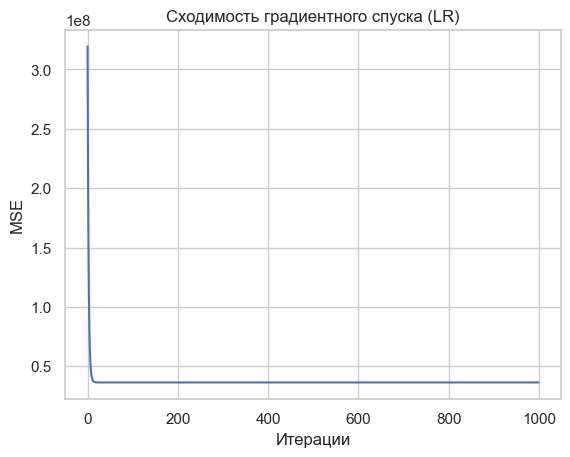

Веса (Градиентный спуск): [13214.1258132   3667.98588468  -126.87434576  2062.82119905
   523.23706138  9477.91275996  -200.68458214  -499.64634368
  -534.36454133]


In [10]:
target = 'charges'
X_train_raw = df_train_proc.drop(columns=[target]).values
y_train = df_train_proc[target].values

X_test_raw = df_test_proc.drop(columns=[target]).values
y_test = df_test_proc[target].values

class CustomScaler:
    def __init__(self):
        self.mean = None
        self.std = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
    def transform(self, X):
        return (X - self.mean) / (self.std + 1e-8) 

scaler = CustomScaler()
scaler.fit(X_train_raw)

X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

X_train = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

print(f"Размер матрицы X_train: {X_train.shape}")

def linear_regression_analytic(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

w_analytic = linear_regression_analytic(X_train, y_train)

print("Веса (Аналитическое решение):", w_analytic)

def linear_regression_gradient_descent(X, y, learning_rate, n_iterations):
    m = len(y)
    w = np.random.randn(X.shape[1]) * 0.01
    
    loss_history = []
    
    for i in range(n_iterations):
        y_pred = X.dot(w)
        
        error = y_pred - y

        gradient = (2/m) * X.T.dot(error)
        
        w = w - learning_rate * gradient

        cost = np.mean(error**2)
        loss_history.append(cost)
        
    return w, loss_history

# Обучение
w_gd, history_gd = linear_regression_gradient_descent(X_train, y_train, learning_rate=0.1, n_iterations=1000)

# График сходимости
plt.plot(history_gd)
plt.title("Сходимость градиентного спуска (LR)")
plt.xlabel("Итерации")
plt.ylabel("MSE")
plt.show()

print("Веса (Градиентный спуск):", w_gd)

Веса (Ridge Аналитика, lambda=10.0): [13214.1258132   3636.05312585  -118.7909399   2042.05015346
   520.31542934  9388.19298092  -193.5373296   -477.54331906
  -522.95133246]
Веса (Ridge GD): [13214.1258132   3667.66393897  -126.79200689  2062.61075267
   523.20779108  9477.00694994  -200.61001185  -499.4196159
  -534.24673251]


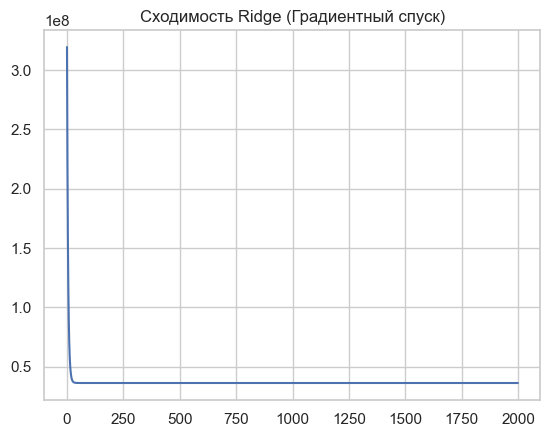

In [6]:
def ridge_regression_analytic(X, y, alpha=1.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0
    
    w = np.linalg.inv(X.T.dot(X) + alpha * I).dot(X.T).dot(y)
    return w

lambda_val = 10.0 
w_ridge_analytic = ridge_regression_analytic(X_train, y_train, alpha=lambda_val)

print(f"Веса (Ridge Аналитика, lambda={lambda_val}):", w_ridge_analytic)

def ridge_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, alpha=1.0):
    m = len(y)
    w = np.random.randn(X.shape[1]) * 0.01
    loss_history = []
    
    for i in range(n_iterations):
        y_pred = X.dot(w)
        error = y_pred - y
        
        w_reg = w.copy()
        w_reg[0] = 0 
        
        gradient = (2/m) * X.T.dot(error) + 2 * (alpha / m) * w_reg
        
        w = w - learning_rate * gradient
        
        # MSE
        cost = np.mean(error**2)
        loss_history.append(cost)
        
    return w, loss_history

w_ridge_gd, history_ridge = ridge_gradient_descent(X_train, y_train, learning_rate=0.05, n_iterations=2000, alpha=0.1)

print(f"Веса (Ridge GD):", w_ridge_gd)


plt.plot(history_ridge)
plt.title("Сходимость Ridge (Градиентный спуск)")
plt.show()

Результаты оценки на тестовых данных:


,Model,MSE,RMSE
0,Constant (Mean),1.540069e+08,12409.953368
1,Linear Analytic,3.717595e+07,6097.208493
2,Linear GD,3.717595e+07,6097.208493
3,Ridge Analytic,3.723649e+07,6102.171015
4,Ridge GD,3.717646e+07,6097.250466


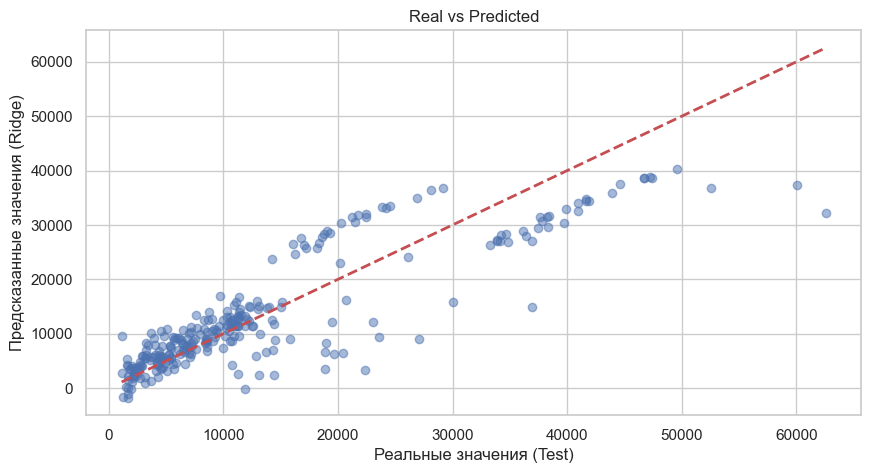

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# 1. Константная модель 
y_pred_const = np.full(len(y_test), np.mean(y_train))
mse_const = mse(y_test, y_pred_const)

# 2. Линейная регрессия (Аналитика)
y_pred_lin_an = X_test.dot(w_analytic)
mse_lin_an = mse(y_test, y_pred_lin_an)

# 3. Линейная регрессия (Градиентный спуск)
y_pred_lin_gd = X_test.dot(w_gd)
mse_lin_gd = mse(y_test, y_pred_lin_gd)

# 4. Ridge (Аналитика)
y_pred_ridge_an = X_test.dot(w_ridge_analytic)
mse_ridge_an = mse(y_test, y_pred_ridge_an)

# 5. Ridge (Градиентный спуск)
y_pred_ridge_gd = X_test.dot(w_ridge_gd)
mse_ridge_gd = mse(y_test, y_pred_ridge_gd)

# Вывод результатов
results = pd.DataFrame({
    'Model': ['Constant (Mean)', 'Linear Analytic', 'Linear GD', 'Ridge Analytic', 'Ridge GD'],
    'MSE': [mse_const, mse_lin_an, mse_lin_gd, mse_ridge_an, mse_ridge_gd],
    'RMSE': [np.sqrt(mse_const), np.sqrt(mse_lin_an), np.sqrt(mse_lin_gd), np.sqrt(mse_ridge_an), np.sqrt(mse_ridge_gd)]
})

print("Результаты оценки на тестовых данных:")
display(results)

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_ridge_an, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения (Test)')
plt.ylabel('Предсказанные значения (Ridge)')
plt.title('Real vs Predicted')
plt.show()